# Case01 — Denpasar Flood Risk Analysis (Debug-ready)

- Notebook tailored for your Denpasar files: `data/raw/dem_denpasar.tif` and `data/raw/Denpasar_rivers.shp`.
- Includes `safe_remove()` to avoid PermissionError on Windows, verbose stats, auto-thresholding, hillshade overlay, and polygonize output.

**How to use**: put your DEM and rivers files in `data/raw/` as shown, open this notebook in the `geo` environment, then `Run → Run All`.


In [1]:

# Cell 1 - Imports & versions
import os, time, warnings
warnings.filterwarnings('ignore')

import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.features import shapes
from shapely.geometry import box, shape
from scipy import ndimage

print('Environment OK')
print('rasterio:', rasterio.__version__)
print('geopandas:', gpd.__version__)
print('numpy:', np.__version__)


Environment OK
rasterio: 1.4.3
geopandas: 1.1.1
numpy: 1.26.4


In [2]:

# Cell 2 - Paths and safe_remove helper (adapt if your repo path differs)
BASE = os.path.abspath(os.path.join(os.getcwd(), '..'))
RAW = os.path.join(BASE, 'data', 'raw')
PROCESSED = os.path.join(BASE, 'data', 'processed')
OUT_MAPS = os.path.join(BASE, 'outputs', 'maps')
OUT_SHAPES = os.path.join(BASE, 'outputs', 'shapefiles')
for d in [RAW, PROCESSED, OUT_MAPS, OUT_SHAPES]:
    os.makedirs(d, exist_ok=True)

print('RAW =', RAW)
print('PROCESSED =', PROCESSED)

def safe_remove(path, wait=0.15, retries=8):
    if os.path.exists(path):
        for i in range(retries):
            try:
                os.remove(path)
                return True
            except PermissionError:
                time.sleep(wait)
        raise PermissionError(f'Could not remove {path} after {retries} retries. Close other apps.')
    return False


RAW = C:\Users\User\turing-geospatial-analyst-portfolio\data\raw
PROCESSED = C:\Users\User\turing-geospatial-analyst-portfolio\data\processed


In [3]:

# Cell 3 - Input filenames (Denpasar)
dem_candidates = ['dem.tif', 'dem_denpasar.tif', 'dem_denpasar_clip.tif']
river_candidates = ['rivers.shp', 'Denpasar_rivers.shp', 'denpasar_rivers.shp']

dem_path = None
for fn in dem_candidates:
    p = os.path.join(RAW, fn)
    if os.path.exists(p):
        dem_path = p
        break

rivers_path = None
for fn in river_candidates:
    p = os.path.join(RAW, fn)
    if os.path.exists(p):
        rivers_path = p
        break

print('dem_path ->', dem_path)
print('rivers_path ->', rivers_path)
if dem_path is None:
    raise FileNotFoundError('DEM not found in data/raw. Please add dem_denpasar.tif and rename to dem.tif or dem_denpasar.tif')
if rivers_path is None:
    raise FileNotFoundError('Rivers shapefile not found in data/raw. Please add Denpasar_rivers.shp (with .dbf/.shx/.prj).')


dem_path -> C:\Users\User\turing-geospatial-analyst-portfolio\data\raw\dem_denpasar.tif
rivers_path -> C:\Users\User\turing-geospatial-analyst-portfolio\data\raw\Denpasar_rivers.shp


In [4]:

# Cell 4 - Build study area from DEM bounds (safe)
with rasterio.open(dem_path) as src:
    dem_crs = src.crs
    dem_bounds = src.bounds
print('DEM CRS:', dem_crs)
print('DEM bounds:', dem_bounds)

study_geom = box(dem_bounds.left, dem_bounds.bottom, dem_bounds.right, dem_bounds.top)
study_gdf = gpd.GeoDataFrame({'id':[1]}, geometry=[study_geom], crs=dem_crs)
print('Study area created from DEM bbox.')


DEM CRS: EPSG:4326
DEM bounds: BoundingBox(left=115.1497918722506, bottom=-8.800211754313843, right=115.35002634908085, top=-8.549851284629732)
Study area created from DEM bbox.


In [5]:

# Cell 5 - Clip DEM to study area and write with explicit nodata
dem_clip_path = os.path.join(PROCESSED, 'dem_clip.tif')
with rasterio.open(dem_path) as src:
    dem_clip, dem_transform = mask(src, study_gdf.geometry, crop=True)
    dem_meta = src.meta.copy()

nodata_val = -9999.0
if hasattr(dem_clip, 'mask'):
    data = dem_clip.filled(nodata_val)
else:
    data = dem_clip
dem_meta.update({'height': data.shape[1], 'width': data.shape[2], 'transform': dem_transform, 'nodata': nodata_val, 'dtype': 'float32'})

if os.path.exists(dem_clip_path):
    safe_remove(dem_clip_path)
with rasterio.open(dem_clip_path, 'w', **dem_meta) as dst:
    dst.write(data.astype('float32'))

print('Saved dem_clip ->', dem_clip_path)


Saved dem_clip -> C:\Users\User\turing-geospatial-analyst-portfolio\data\processed\dem_clip.tif


In [6]:

# Cell 6 - Reproject clipped DEM to UTM (auto zone) and save
centroid = study_gdf.to_crs('EPSG:4326').geometry.centroid.iloc[0]
lon, lat = centroid.x, centroid.y
utm_zone = int((lon + 180) / 6) + 1
epsg_utm = 32600 + utm_zone if lat >= 0 else 32700 + utm_zone
print('Computed UTM EPSG:', epsg_utm)

dem_utm_path = os.path.join(PROCESSED, 'dem_utm.tif')
with rasterio.open(dem_clip_path) as src:
    transform, width, height = calculate_default_transform(src.crs, f'EPSG:{epsg_utm}', src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({'crs': f'EPSG:{epsg_utm}', 'transform': transform, 'width': width, 'height': height})
    if os.path.exists(dem_utm_path):
        safe_remove(dem_utm_path)
    with rasterio.open(dem_utm_path, 'w', **kwargs) as dst:
        for i in range(1, src.count+1):
            reproject(source=rasterio.band(src, i), destination=rasterio.band(dst, i), src_crs=src.crs, dst_crs=f'EPSG:{epsg_utm}', src_transform=src.transform, dst_transform=transform, resampling=Resampling.bilinear)
print('Saved dem_utm ->', dem_utm_path)


Computed UTM EPSG: 32750
Saved dem_utm -> C:\Users\User\turing-geospatial-analyst-portfolio\data\processed\dem_utm.tif


In [7]:

# Cell 7 - Compute slope (numpy-based) with safety & stats
with rasterio.open(dem_utm_path) as src:
    elev = src.read(1).astype('float32')
    meta = src.meta.copy()
    transform = src.transform

px = abs(transform.a)
py = abs(transform.e) if transform.e != 0 else px

dzdx = (np.roll(elev, -1, axis=1) - np.roll(elev, 1, axis=1)) / (2*px)
dzdy = (np.roll(elev, -1, axis=0) - np.roll(elev, 1, axis=0)) / (2*py)
dzdx[:,0] = (elev[:,1] - elev[:,0]) / px
dzdx[:,-1] = (elev[:,-1] - elev[:,-2]) / px
dzdy[0,:] = (elev[1,:] - elev[0,:]) / py
dzdy[-1,:] = (elev[-1,:] - elev[-2,:]) / py

slope_rad = np.arctan(np.sqrt(dzdx**2 + dzdy**2))
slope_deg = np.degrees(slope_rad)

slope_path = os.path.join(PROCESSED, 'slope.tif')
meta.update({'dtype':'float32','count':1,'nodata': nodata_val})
if os.path.exists(slope_path):
    safe_remove(slope_path)
with rasterio.open(slope_path, 'w', **meta) as dst:
    dst.write(slope_deg.astype('float32'), 1)

print('Saved slope ->', slope_path)
print('DEM stats min,max,mean:', elev.min(), elev.max(), elev.mean())
print('Slope stats min,max,mean:', np.nanmin(slope_deg), np.nanmax(slope_deg), np.nanmean(slope_deg))


Saved slope -> C:\Users\User\turing-geospatial-analyst-portfolio\data\processed\slope.tif
DEM stats min,max,mean: -9999.0 154.15549 -61.11818
Slope stats min,max,mean: 0.0 89.8492 2.2066514


In [8]:

# Cell 8 - Read rivers shapefile, check CRS, reproject to UTM, rasterize, compute distance-to-river
rivers = gpd.read_file(rivers_path)
print('Rivers original CRS:', rivers.crs)
rivers_utm = rivers.to_crs(epsg_utm)

with rasterio.open(dem_utm_path) as src:
    out_meta = src.meta.copy()
    river_raster = rasterio.features.rasterize(((geom,1) for geom in rivers_utm.geometry), out_shape=(src.height, src.width), transform=src.transform, fill=0, dtype='uint8')

res_x = abs(out_meta['transform'][0])
res_y = abs(out_meta['transform'][4]) if out_meta['transform'][4] != 0 else res_x
pix_size = (res_x + res_y)/2.0

dist_pix = ndimage.distance_transform_edt(1 - river_raster)
dist_m = dist_pix * pix_size

dist_path = os.path.join(PROCESSED, 'dist_to_river.tif')
if os.path.exists(dist_path):
    safe_remove(dist_path)
with rasterio.open(dist_path, 'w', **out_meta) as dst:
    dst.write(dist_m.astype('float32'), 1)

print('Saved dist_to_river ->', dist_path)
print('Dist stats min,max,mean:', dist_m.min(), dist_m.max(), dist_m.mean())


Rivers original CRS: EPSG:4326
Saved dist_to_river -> C:\Users\User\turing-geospatial-analyst-portfolio\data\processed\dist_to_river.tif
Dist stats min,max,mean: 0.0 14615.765029857655 2295.6107545495574


In [9]:

# Cell 9 - Auto-threshold scoring (percentile-based) and save rasters
# compute percentiles for adaptive thresholds
valid_elev = elev[np.isfinite(elev) & (elev != nodata_val)]
p10, p50, p90 = np.percentile(valid_elev, [10,50,90])
print('elev percentiles p10,p50,p90:', p10, p50, p90)

# thresholds for distance: use percentiles too
valid_dist = dist_m[np.isfinite(dist_m)]
d20, d60 = np.percentile(valid_dist, [20,60])
print('dist percentiles d20,d60:', d20, d60)

# scoring rules (adaptive)
score_elev = np.where(elev < p10, 3, np.where(elev < p50, 2, 1))
score_slope = np.where(slope_deg < 1, 1, 0)  # low slope gives slight extra risk (low-lying)
score_dist = np.where(dist_m < d20, 3, np.where(dist_m < d60, 2, 1))

risk = score_elev + score_slope + score_dist
risk_class = np.full(risk.shape, 0, dtype='uint8')
risk_class[risk <= 3] = 1
risk_class[(risk >=4) & (risk <=6)] = 2
risk_class[(risk >=7) & (risk <=8)] = 3
risk_class[risk >=9] = 4

risk_path = os.path.join(PROCESSED, 'risk_index.tif')
class_path = os.path.join(PROCESSED, 'risk_class.tif')
out_meta = out_meta.copy()
out_meta.update(dtype='float32')

if os.path.exists(risk_path): safe_remove(risk_path)
with rasterio.open(risk_path, 'w', **out_meta) as dst:
    dst.write(risk.astype('float32'), 1)
if os.path.exists(class_path): safe_remove(class_path)
with rasterio.open(class_path, 'w', **out_meta) as dst:
    dst.write(risk_class.astype('uint8'), 1)

print('Saved risk rasters:', risk_path, class_path)
print('Risk class unique counts:', np.unique(risk_class, return_counts=True))


elev percentiles p10,p50,p90: 0.0 7.0 98.61653442382817
dist percentiles d20,d60: 148.75251129503943 1160.2695881013076
Saved risk rasters: C:\Users\User\turing-geospatial-analyst-portfolio\data\processed\risk_index.tif C:\Users\User\turing-geospatial-analyst-portfolio\data\processed\risk_class.tif
Risk class unique counts: (array([1, 2, 3], dtype=uint8), array([198556, 496834,    440], dtype=int64))


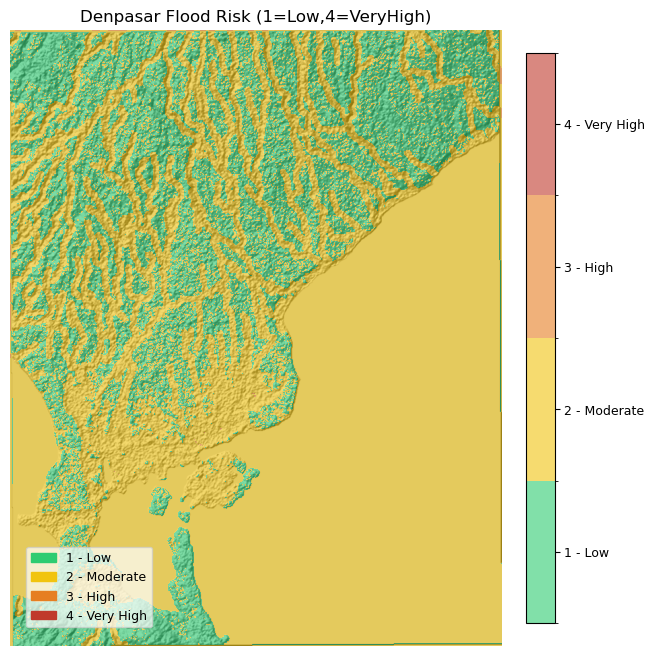

Saved map PNG -> C:\Users\User\turing-geospatial-analyst-portfolio\outputs\maps\denpasar_flood_risk_map_with_legend.png


In [12]:

# Cell 10 replacement - Hillshade + discrete colorbar + legend and save PNG
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

def hillshade(arr, az=315, alt=45):
    x, y = np.gradient(arr.astype('float32'))
    slope = np.pi/2. - np.arctan(np.sqrt(x*x + y*y))
    aspect = np.arctan2(-x, y)
    azr = az*np.pi/180.
    altr = alt*np.pi/180.
    shaded = np.sin(altr)*np.sin(slope) + np.cos(altr)*np.cos(slope)*np.cos(azr - aspect)
    return shaded

hs = hillshade(elev)

# Discrete colormap for 4 classes (1..4)
colors = ['#2ecc71', '#f1c40f', '#e67e22', '#c0392b']  # low->veryhigh
cmap = mcolors.ListedColormap(colors)
bounds = [0.5, 1.5, 2.5, 3.5, 4.5]    # boundaries between classes
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create figure & axes with room for colorbar on the right
fig, ax = plt.subplots(figsize=(8,8))
# show hillshade as background (grayscale)
im_hs = ax.imshow(hs, cmap='gray', interpolation='bilinear', extent=None)

# show discrete risk_class on top (use norm so values map correctly)
# IMPORTANT: pass the mappable returned by imshow to colorbar
im_risk = ax.imshow(risk_class, cmap=cmap, norm=norm, interpolation='nearest', alpha=0.6)

ax.set_title('Denpasar Flood Risk (1=Low,4=VeryHigh)')
ax.axis('off')

# colorbar for discrete classes: use the mappable (im_risk) and set ticks at class centers
cbar = fig.colorbar(im_risk, ax=ax, boundaries=bounds, ticks=[1,2,3,4], fraction=0.046, pad=0.04)
cbar.ax.set_yticklabels(['1 - Low','2 - Moderate','3 - High','4 - Very High'], fontsize=9)

# OPTIONAL: add legend boxes (useful if you prefer legend instead of colorbar labels)
patches = [
    mpatches.Patch(color=colors[0], label='1 - Low'),
    mpatches.Patch(color=colors[1], label='2 - Moderate'),
    mpatches.Patch(color=colors[2], label='3 - High'),
    mpatches.Patch(color=colors[3], label='4 - Very High'),
]
# place legend outside the map (bottom-left)
ax.legend(handles=patches, loc='lower left', bbox_to_anchor=(0.02, 0.02), fontsize=9, framealpha=0.7)

# Save with colorbar included
out_png = os.path.join(OUT_MAPS, 'denpasar_flood_risk_map_with_legend.png')
if os.path.exists(out_png):
    safe_remove(out_png)
plt.savefig(out_png, dpi=300, bbox_inches='tight')
plt.show()

print('Saved map PNG ->', out_png)


In [11]:

# Cell 11 - Polygonize classes and save GPKG (debug info included)
with rasterio.open(class_path) as src:
    arr = src.read(1)
    tr = src.transform

shp_list = []
for geom, val in shapes(arr, mask=arr>0, transform=tr):
    shp_list.append({'geometry': shape(geom), 'risk': int(val)})

gdf = gpd.GeoDataFrame(shp_list, crs=f'EPSG:{epsg_utm}')
gdf = gdf.dissolve(by='risk')

out_gpkg = os.path.join(OUT_SHAPES, 'denpasar_flood_risk_zones.gpkg')
if os.path.exists(out_gpkg): safe_remove(out_gpkg)
gdf.to_file(out_gpkg, driver='GPKG')
print('Saved GPKG ->', out_gpkg)
print('Summary:', gdf['geometry'].geom_type.value_counts())

# final quick checks
print('Files in processed:')
print(os.listdir(PROCESSED))
print('Files in outputs/maps:')
print(os.listdir(OUT_MAPS))
print('Files in outputs/shapefiles:')
print(os.listdir(OUT_SHAPES))


Saved GPKG -> C:\Users\User\turing-geospatial-analyst-portfolio\outputs\shapefiles\denpasar_flood_risk_zones.gpkg
Summary: MultiPolygon    3
Name: count, dtype: int64
Files in processed:
['dem_clip.tif', 'dem_utm.tif', 'dist_to_river.tif', 'risk_class.tif', 'risk_index.tif', 'slope.tif']
Files in outputs/maps:
['.ipynb_checkpoints', 'denpasar_flood_risk_map.png', 'flood_risk_map.png']
Files in outputs/shapefiles:
['denpasar_flood_risk_zones.gpkg', 'flood_risk_zones.gpkg']
